<a href="https://colab.research.google.com/github/PavelStelmakhV/hw310-keras-fasion-mnist/blob/main/keras_fasion_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [145]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras import regularizers
from keras import callbacks
from keras import initializers
from keras.layers import BatchNormalization

In [146]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [147]:
# x_train = x_train.reshape(60000, 784).astype('float32') / 255
# x_test = x_test.reshape(10000, 784).astype('float32') / 255
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Перемешаем тренировочные данные
# train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [148]:
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [149]:
w_init = initializers.glorot_normal()
b_init = initializers.Zeros()

# model = Sequential()
# model.add(Dense(n_dense,
#                 input_dim=n_input,
#                 kernel_initializer=w_init,
#                 bias_initializer=b_init))
# model.add(Activation('sigmoid'))

In [150]:
model = tf.keras.Sequential()

drop_out = 0.0
lern_rat = 0.00001
neurons = 256

model.add(layers.Flatten(input_shape=(28, 28)))
model.add(layers.Dense(neurons * 1, activation='relu', kernel_initializer=w_init, bias_initializer=b_init)) #, kernel_regularizer=regularizers.l2(lern_rat)
# model.add(BatchNormalization())
# model.add(layers.Dropout(drop_out))
model.add(layers.Dense(neurons * 2, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(drop_out))

model.add(layers.Dense(neurons * 2, activation='tanh'))
model.add(BatchNormalization())
model.add(layers.Dropout(drop_out))

model.add(layers.Dense(neurons * 4, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(drop_out))

model.add(layers.Dense(10, activation='softmax'))

In [151]:
model.compile(#optimizer='adam',
              optimizer='adamax',
              # optimizer='nadam',
              # optimizer='rmsprop',
              # optimizer='sgd',
              # optimizer='adadelta',
              # loss='binary_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])

1/1 [==============================] - 0s 106ms/step


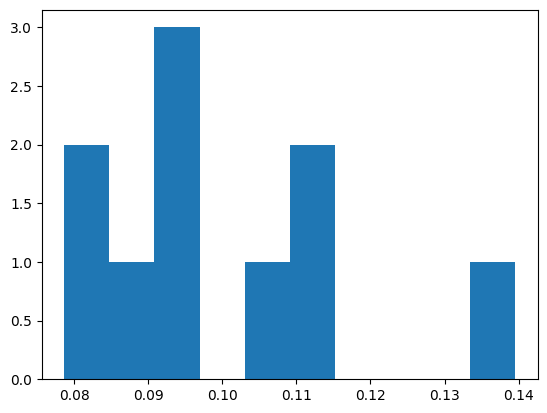

In [152]:
x = np.random.random((1, 28, 28))
a = model.predict(x)
_ = plt.hist(np.transpose(a))

In [153]:
callback = callbacks.EarlyStopping(monitor='val_loss', patience=12)

In [154]:
# model.fit(train_images, train_labels, epochs=20)
history = model.fit(x_train, y_train,
                    epochs=120,
                    batch_size=32,
                    callbacks=[callback],
                    verbose=1, #многословие
                    validation_data=(x_val, y_val))
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest accuracy:', test_acc)

Epoch 1/120
1563/1563 [==============================] - 12s 6ms/step - loss: 0.5366 - sparse_categorical_accuracy: 0.8140 - val_loss: 0.4341 - val_sparse_categorical_accuracy: 0.8409
Epoch 2/120
1563/1563 [==============================] - 9s 6ms/step - loss: 0.3995 - sparse_categorical_accuracy: 0.8562 - val_loss: 0.4822 - val_sparse_categorical_accuracy: 0.8135
Epoch 3/120
1563/1563 [==============================] - 9s 6ms/step - loss: 0.3531 - sparse_categorical_accuracy: 0.8701 - val_loss: 0.4024 - val_sparse_categorical_accuracy: 0.8438
Epoch 4/120
1563/1563 [==============================] - 9s 6ms/step - loss: 0.3163 - sparse_categorical_accuracy: 0.8834 - val_loss: 0.3806 - val_sparse_categorical_accuracy: 0.8650
Epoch 5/120
1563/1563 [==============================] - 9s 6ms/step - loss: 0.2899 - sparse_categorical_accuracy: 0.8922 - val_loss: 0.3607 - val_sparse_categorical_accuracy: 0.8663
Epoch 6/120
1563/1563 [==============================] - 9s 6ms/step - loss: 0.2712 

In [155]:
print('\nhistory dict:', list(history.history.keys()))


history dict: ['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy']


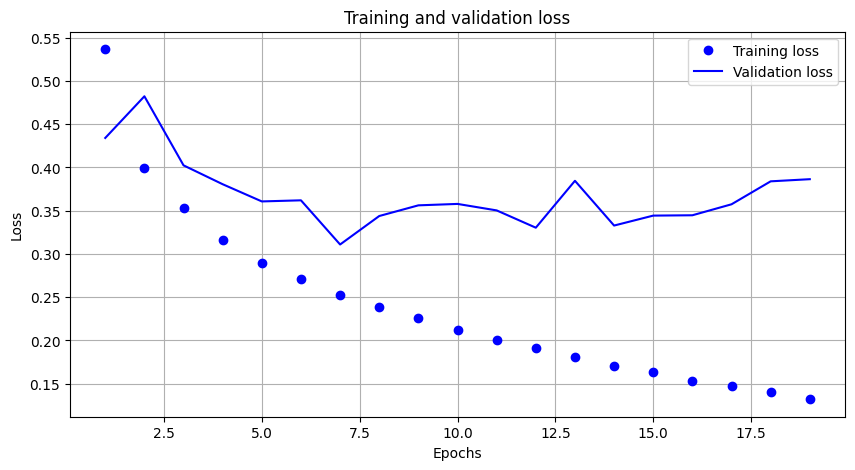

<Figure size 640x480 with 0 Axes>

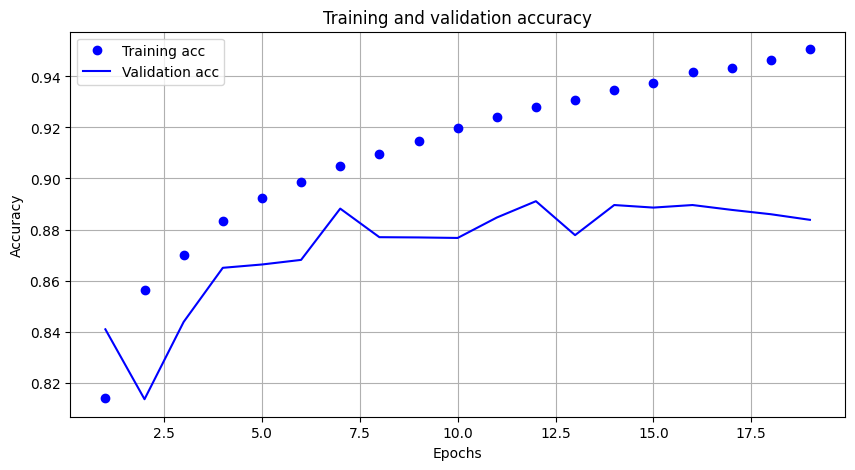

In [156]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.clf()
plt.figure(figsize=(10, 5))
val_acc_values = history_dict['sparse_categorical_accuracy']
plt.plot(epochs, history_dict['sparse_categorical_accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_sparse_categorical_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [157]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [158]:
predictions = probability_model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [159]:
predictions[0]

array([0.0853396 , 0.0853396 , 0.0853396 , 0.0853396 , 0.0853396 ,
       0.08533961, 0.0853396 , 0.08535908, 0.0853396 , 0.23192406],
      dtype=float32)

In [160]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 dense_39 (Dense)            (None, 256)               200960    
                                                                 
 dense_40 (Dense)            (None, 512)               131584    
                                                                 
 batch_normalization_20 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dropout_20 (Dropout)        (None, 512)               0         
                                                                 
 dense_41 (Dense)            (None, 512)               262656    
                                                     